<a href="https://colab.research.google.com/github/Subhas-1130/Subhas-demo/blob/main/002211001130_SUBHAS_CHANDRA_SHIT_ASSIGNMENT_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install gymnasium


RL (Q-learning) for Mountain Car Problem

In [6]:
import gymnasium as gym
import numpy as np

# Create the MountainCar environment
env = gym.make('MountainCar-v0')

# Set the number of episodes and learning parameters
num_episodes = 1000
learning_rate = 0.1
discount_factor = 0.99
epsilon = 0.1  # Exploration rate

# Discretize the continuous space
n_bins = 24
position_bins = np.linspace(-1.2, 0.6, n_bins)
velocity_bins = np.linspace(-0.07, 0.07, n_bins)

# Initialize Q-table
q_table = np.zeros((len(position_bins) + 1, len(velocity_bins) + 1, env.action_space.n))

def discretize_state(state):
    position, velocity = state
    position_idx = np.digitize(position, position_bins) - 1
    velocity_idx = np.digitize(velocity, velocity_bins) - 1
    return position_idx, velocity_idx

# Q-learning loop
for episode in range(num_episodes):
    state, _ = env.reset()  # Reset environment
    done = False
    total_reward = 0

    while not done:
        # Discretize the state
        position_idx, velocity_idx = discretize_state(state)

        # Exploration vs. Exploitation
        if np.random.rand() < epsilon:
            action = env.action_space.sample()  # Explore
        else:
            action = np.argmax(q_table[position_idx, velocity_idx])  # Exploit

        # Take the action and get the next state and reward
        next_state, reward, done, _, _ = env.step(action)
        next_position_idx, next_velocity_idx = discretize_state(next_state)

        # Q-value update rule
        best_next_action = np.argmax(q_table[next_position_idx, next_velocity_idx])
        q_table[position_idx, velocity_idx, action] += learning_rate * (
            reward + discount_factor * q_table[next_position_idx, next_velocity_idx, best_next_action] - q_table[position_idx, velocity_idx, action]
        )

        state = next_state  # Move to the next state
        total_reward += reward

    if episode % 100 == 0:
        print(f"Episode {episode}, Total reward: {total_reward}")

env.close()


Episode 0, Total reward: -14552.0
Episode 100, Total reward: -337.0
Episode 200, Total reward: -322.0
Episode 300, Total reward: -319.0
Episode 400, Total reward: -250.0
Episode 500, Total reward: -294.0
Episode 600, Total reward: -323.0
Episode 700, Total reward: -396.0
Episode 800, Total reward: -301.0
Episode 900, Total reward: -205.0


RL (Q-learning) for Car Racing Problem

In [7]:
!pip install gymnasium[all]

  Using cached box2d-py-2.3.5.tar.gz (374 kB)
  Preparing metadata (setup.py) ... done
  Using cached swig-4.4.0-py3-none-manylinux_2_12_x86_64.manylinux2010_x86_64.whl.metadata (3.5 kB)
  Using cached mujoco-3.3.7-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (41 kB)
  Using cached glfw-2.10.0-py2.py27.py3.py30.py31.py32.py33.py34.py35.py36.py37.py38.p39.p310.p311.p312.p313-none-manylinux_2_28_x86_64.whl.metadata (5.4 kB)
INFO: pip is looking at multiple versions of shimmy[atari] to determine which version is compatible with other requirements. This could take a while.
  Using cached array_api_compat-1.12.0-py3-none-any.whl.metadata (2.5 kB)
  Using cached numpy-2.3.4-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (62 kB)
  Using cached numpy-2.2.6-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
Using cached swig-4.4.0-py3-none-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (1.9 MB)
Using cached array_api_compat-

In [8]:
!setup.py build
!setup.py install


/bin/bash: line 1: setup.py: command not found
/bin/bash: line 1: setup.py: command not found


In [9]:
import gymnasium as gym
import numpy as np

# Create the CartPole environment
# Using render_mode='rgb_array' if you want to record videos later, otherwise can be None
env = gym.make('CartPole-v1')

# Set up parameters for Q-learning
n_actions = env.action_space.n

# Discretize the state space for CartPole
# The observation space is Box(4) - cart position, cart velocity, pole angle, pole angular velocity
# We need to define bins for each of these four dimensions.
# The ranges for these observations are technically unbounded, but in practice, they stay within certain limits.
# We'll use some reasonable bounds and number of bins for discretization.

# Define bins for each observation dimension
# Number of bins for each dimension - adjust as needed for desired granularity
num_bins = (10, 10, 10, 10)

# Define the ranges for discretization for each observation dimension
# These ranges are approximate based on typical CartPole behavior
# You might need to adjust these based on observation during training
obs_ranges = [
    (-2.4, 2.4),   # Cart Position (actually limited by the environment)
    (-4.0, 4.0),   # Cart Velocity (can be large, use a reasonable range)
    (-0.418, 0.418), # Pole Angle (approx -24 degrees to +24 degrees in radians)
    (-4.0, 4.0)    # Pole Angular Velocity (can be large, use a reasonable range)
]

# Create the discretization bins
bins = [np.linspace(obs_ranges[i][0], obs_ranges[i][1], num_bins[i]) for i in range(len(num_bins))]

# Calculate the size of the discretized state space
n_states = tuple(num_bins)

# Initialize Q-table
q_table = np.zeros(n_states + (n_actions,))

# Q-learning parameters
learning_rate = 0.1
discount_factor = 0.99
epsilon = 1.0  # Start with high exploration
epsilon_decay_rate = 0.999 # Decay epsilon over episodes
min_epsilon = 0.01 # Minimum exploration rate
num_episodes = 2000 # Increase episodes for better learning

# Function to discretize the state
def discretize_state(state):
    """
    Discretize the continuous state of the CartPole environment.
    """
    discrete_state = []
    for i in range(len(state)):
        # Use np.digitize to find which bin the observation falls into
        # Subtract 1 to get a 0-based index
        discrete_state.append(np.digitize(state[i], bins[i]) - 1)
    # Ensure indices are within bounds after digitize
    discrete_state = [max(0, min(idx, num_bins[i] - 1)) for i, idx in enumerate(discrete_state)]
    return tuple(discrete_state)

# Q-learning loop
for episode in range(num_episodes):
    state, info = env.reset()  # Reset environment, get initial state and info
    state = discretize_state(state)
    done = False
    total_reward = 0

    while not done:
        # Exploration vs. Exploitation
        if np.random.rand() < epsilon:
            action = env.action_space.sample()  # Explore action space
        else:
            action = np.argmax(q_table[state])  # Exploit learned values

        # Take the action and get the next state and reward
        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated

        next_state = discretize_state(next_state)

        # Q-value update rule (Temporal Difference learning)
        # Q(s,a) = Q(s,a) + alpha * (reward + gamma * max(Q(s',a')) - Q(s,a))
        best_next_action = np.argmax(q_table[next_state])
        q_table[state + (action,)] += learning_rate * (
            reward + discount_factor * np.max(q_table[next_state]) - q_table[state + (action,)]
        )

        state = next_state  # Move to the next state
        total_reward += reward

    # Decay epsilon
    epsilon = max(min_epsilon, epsilon * epsilon_decay_rate)

    if episode % 100 == 0:
        print(f"Episode {episode}, Total reward: {total_reward}, Epsilon: {epsilon:.2f}")

env.close()

print("\nTraining finished!")

# Optional: Test the trained agent (run after the training loop)
# You can render the environment during testing to visualize the agent's performance
# test_env = gym.make('CartPole-v1', render_mode='human') # Use render_mode='human' to visualize
# state, info = test_env.reset()
# state = discretize_state(state)
# total_test_reward = 0
# done = False
# while not done:
#     action = np.argmax(q_table[state]) # Choose best action based on learned Q-values
#     next_state, reward, terminated, truncated, info = test_env.step(action)
#     done = terminated or truncated
#     state = discretize_state(next_state)
#     total_test_reward += reward
# test_env.close()
# print(f"Test Reward: {total_test_reward}")

Episode 0, Total reward: 24.0, Epsilon: 1.00
Episode 100, Total reward: 16.0, Epsilon: 0.90
Episode 200, Total reward: 21.0, Epsilon: 0.82
Episode 300, Total reward: 20.0, Epsilon: 0.74
Episode 400, Total reward: 27.0, Epsilon: 0.67
Episode 500, Total reward: 26.0, Epsilon: 0.61
Episode 600, Total reward: 21.0, Epsilon: 0.55
Episode 700, Total reward: 29.0, Epsilon: 0.50
Episode 800, Total reward: 19.0, Epsilon: 0.45
Episode 900, Total reward: 25.0, Epsilon: 0.41
Episode 1000, Total reward: 20.0, Epsilon: 0.37
Episode 1100, Total reward: 17.0, Epsilon: 0.33
Episode 1200, Total reward: 83.0, Epsilon: 0.30
Episode 1300, Total reward: 27.0, Epsilon: 0.27
Episode 1400, Total reward: 24.0, Epsilon: 0.25
Episode 1500, Total reward: 20.0, Epsilon: 0.22
Episode 1600, Total reward: 26.0, Epsilon: 0.20
Episode 1700, Total reward: 11.0, Epsilon: 0.18
Episode 1800, Total reward: 19.0, Epsilon: 0.16
Episode 1900, Total reward: 25.0, Epsilon: 0.15

Training finished!


RL (Q-learning) for Roulette

In [10]:
import numpy as np
import random

# Parameters for the Roulette environment
wheel_numbers = list(range(37))  # Numbers 0 to 36 on a roulette wheel
bet_amount = 1  # Fixed bet amount per spin
win_reward = 35  # Reward multiplier for winning bet
total_bankroll = 100  # Initial bankroll
epsilon = 0.1  # Exploration rate
alpha = 0.1  # Learning rate
gamma = 0.9  # Discount factor
episodes = 1000  # Number of training episodes

# Initialize Q-table for betting actions
Q = np.zeros(len(wheel_numbers))

# Function to simulate the roulette wheel spin (uniform random choice)
def spin_roulette():
    return random.choice(wheel_numbers)

# Q-learning Algorithm for Roulette
def q_learning():
    global total_bankroll

    for episode in range(episodes):
        # State representation in this simplified example is not explicitly used in the Q-table lookup,
        # but the bankroll changes based on actions and rewards.
        # If the state was incorporated into the Q-table, it would need discretization.
        # state = total_bankroll # Using bankroll as a state would require discretizing it for a tabular Q-table

        # Choose action (bet on a number) using epsilon-greedy
        if random.random() < epsilon:
            action = random.choice(wheel_numbers)  # Random bet
        else:
            # In this simplified example, state is not directly used in Q-table lookup.
            # The Q-table stores values per action (number to bet on).
            action = np.argmax(Q)  # Bet on the number with the highest Q-value

        # Simulate the roulette spin and check if the bet wins
        spin_result = spin_roulette()

        if action == spin_result:  # Win the bet
            reward = bet_amount * win_reward  # Winning bet reward
        else:
            reward = -bet_amount  # Lose the bet

        # Update Q-table using the Q-learning formula
        # Here, the state is implicitly the decision point before betting.
        # The update is on the Q-value of the chosen action (the number bet on).
        Q[action] = Q[action] + alpha * (reward + gamma * np.max(Q) - Q[action])

        # Update bankroll - this is part of the environment interaction / consequence
        total_bankroll += reward

        if episode % 100 == 0:
             # Check bankroll status periodically
            if total_bankroll <= 0:
                print(f"Episode {episode}, Bankroll is depleted, stopping training.")
                break
            print(f"Episode {episode}, Bankroll: {total_bankroll}")


    print("Training finished!")

# Test the trained Q-learning agent
def test_q_learning():
    global total_bankroll # Declare total_bankroll as global to modify it
    # Note: In a proper RL setup, the test would usually start from a fresh state
    # and not rely on the final bankroll from training, but this follows the
    # structure of the provided code.
    initial_test_bankroll = total_bankroll # Start test with the bankroll after training
    winnings = 0
    for spin_count in range(100):  # Run 100 spins to test performance
        # Choose action (bet on a number) based on learned Q-values
        # In this simplified model, the state of the system (bankroll)
        # is not used in the action selection during testing.
        action = np.argmax(Q)  # Bet on the number with the highest Q-value

        spin_result = spin_roulette()

        if action == spin_result:
            reward = bet_amount * win_reward
        else:
            reward = -bet_amount

        total_bankroll += reward
        winnings += reward

    print(f"Test completed. Final bankroll: {total_bankroll}, Winnings: {winnings}")

# Run Q-learning
q_learning()

# Run Test
test_q_learning()

Episode 0, Bankroll: 99
Episode 100, Bankroll: 107
Episode 200, Bankroll: 115
Episode 300, Bankroll: 123
Episode 400, Bankroll: 131
Episode 500, Bankroll: 67
Episode 600, Bankroll: 39
Episode 700, Bankroll is depleted, stopping training.
Training finished!
Test completed. Final bankroll: -53, Winnings: 8


✅ Q-Learning training completed.

🏁 Shortest Path (RL): [0, np.int64(1), np.int64(0), np.int64(1), np.int64(0)]


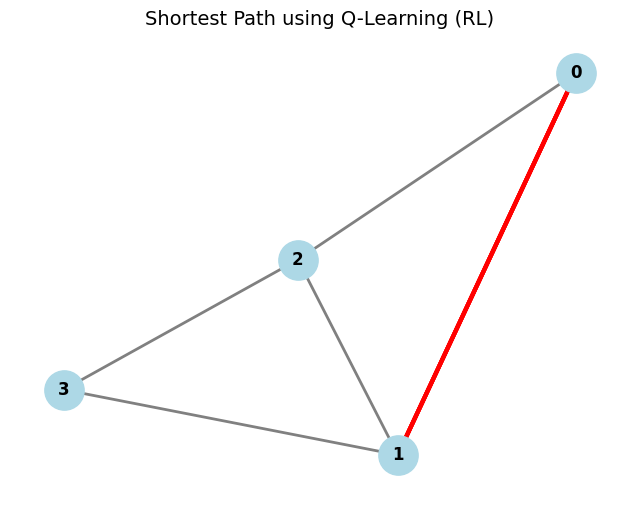

In [11]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import random

# === Step 1: Create the Graph (User-input or predefined) ===
# You can replace this with your own adjacency matrix or graph
G = nx.Graph()
edges = [
    (0, 1, 1),
    (0, 2, 4),
    (1, 2, 2),
    (1, 3, 6),
    (2, 3, 3)
]
G.add_weighted_edges_from(edges)

n_states = len(G.nodes)
goal_state = 3  # destination node

# === Step 2: Initialize Q-Learning parameters ===
alpha = 0.1       # learning rate
gamma = 0.9       # discount factor
epsilon = 0.2     # exploration rate
num_episodes = 500

q_table = np.zeros((n_states, n_states))

# Reward Matrix (negative cost to encourage shortest path)
reward_matrix = np.full((n_states, n_states), -100.0)
for (u, v, w) in edges:
    reward_matrix[u, v] = -w  # negative weight as cost
    reward_matrix[v, u] = -w

# === Step 3: Q-Learning Training ===
for episode in range(num_episodes):
    state = random.choice(list(G.nodes))
    done = False

    while not done:
        # Epsilon-greedy action selection
        if random.random() < epsilon:
            possible_actions = [v for v in G.neighbors(state)]
            action = random.choice(possible_actions)
        else:
            action = np.argmax(q_table[state])

        reward = reward_matrix[state, action]
        next_state = action

        # Update rule
        q_table[state, action] += alpha * (
            reward + gamma * np.max(q_table[next_state]) - q_table[state, action]
        )

        state = next_state
        if state == goal_state:
            done = True

print("✅ Q-Learning training completed.\n")

# === Step 4: Extract Best Path using Q-table ===
def find_best_path(start, goal):
    path = [start]
    current = start
    while current != goal:
        next_state = np.argmax(q_table[current])
        path.append(next_state)
        current = next_state
        if len(path) > n_states:  # to avoid loops
            break
    return path

start_node = 0
best_path_rl = find_best_path(start_node, goal_state)
print(f"🏁 Shortest Path (RL): {best_path_rl}")

# === Step 5: Plot Graph (RL Path in RED) ===
pos = nx.spring_layout(G, seed=42)
plt.figure(figsize=(8, 6))

# Draw all edges in gray
nx.draw_networkx_edges(G, pos, edge_color='gray', width=2)
nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=800)
nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold')

# Highlight best path in red
path_edges = list(zip(best_path_rl, best_path_rl[1:]))
nx.draw_networkx_edges(G, pos, edgelist=path_edges, edge_color='red', width=3)

plt.title("Shortest Path using Q-Learning (RL)", fontsize=14)
plt.axis('off')
plt.show()


DRL Implementation using DQN

In [12]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque

# Define the DQN Model
class DQN(nn.Module):
    def __init__(self, state_space, action_space):
        super(DQN, self).__init__()
        # Flatten the state space for the linear layers if it's not 1D
        input_dim = np.prod(state_space) if isinstance(state_space, tuple) else state_space
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, action_space)

    def forward(self, state):
        # Ensure the state is flattened if necessary
        if isinstance(state, np.ndarray) and state.ndim > 1:
             state = state.view(state.size(0), -1)
        elif isinstance(state, torch.Tensor) and state.ndim > 1:
            state = state.view(state.size(0), -1)

        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Set up environment
# Ensure the environment is created with the new API which returns obs, info on reset
env = gym.make('MountainCar-v0')

# Set up parameters
state_space = env.observation_space.shape
action_space = env.action_space.n
learning_rate = 0.001
gamma = 0.99
epsilon = 1.0  # Start with high exploration
epsilon_decay = 0.995
batch_size = 64
episodes = 100

# Initialize the DQN model
model = DQN(state_space, action_space)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

# Experience Replay buffer
buffer = deque(maxlen=10000)

def select_action(state, epsilon):
    if random.random() < epsilon:
        return env.action_space.sample()  # Random action
    else:
        # Ensure state is a torch tensor and has the correct shape for the model
        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        q_values = model(state)
        return torch.argmax(q_values).item()

# Training Loop
for episode in range(episodes):
    # Use the new reset API
    state, info = env.reset()
    # Ensure state is a numpy array before processing
    state = np.array(state)
    total_reward = 0

    # Adjust the loop to use the new step API return values
    for t in range(200): # Limiting steps per episode
        action = select_action(state, epsilon)
        # Use the new step API
        next_state, reward, terminated, truncated, info = env.step(action)
        # Ensure next_state is a numpy array
        next_state = np.array(next_state)
        done = terminated or truncated # New way to check if episode is done

        buffer.append((state, action, reward, next_state, done))

        # Sample a batch from the replay buffer
        if len(buffer) > batch_size:
            batch = random.sample(buffer, batch_size)
            states, actions, rewards, next_states, dones = zip(*batch)

            # Convert to torch tensors
            states = torch.tensor(np.array(states), dtype=torch.float32)
            next_states = torch.tensor(np.array(next_states), dtype=torch.float32)
            actions = torch.tensor(np.array(actions))
            rewards = torch.tensor(np.array(rewards), dtype=torch.float32)
            dones = torch.tensor(np.array(dones), dtype=torch.float32)

            # Compute Q-values
            q_values = model(states)
            next_q_values = model(next_states)

            # Compute the target Q-values
            # Use next_q_values.max(1)[0] for the maximum Q-value over actions for each state in the batch
            target_q_values = rewards + (gamma * next_q_values.max(1)[0] * (1 - dones))

            # Update the Q-values for the chosen actions
            # Use gather to select the Q-values corresponding to the actions taken
            q_values = q_values.gather(1, actions.unsqueeze(1)).squeeze(1)

            loss = criterion(q_values, target_q_values)

            # Optimize the model
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        state = next_state  # Move to the next state
        total_reward += reward

        if done:
            break

    # Decay epsilon
    epsilon = max(min_epsilon, epsilon * epsilon_decay)
    print(f"Episode {episode}, Total Reward: {total_reward}")

print("Training finished!")

env.close()

Episode 0, Total Reward: -200.0
Episode 1, Total Reward: -200.0
Episode 2, Total Reward: -200.0
Episode 3, Total Reward: -200.0
Episode 4, Total Reward: -200.0
Episode 5, Total Reward: -200.0
Episode 6, Total Reward: -200.0
Episode 7, Total Reward: -200.0
Episode 8, Total Reward: -200.0
Episode 9, Total Reward: -200.0
Episode 10, Total Reward: -200.0
Episode 11, Total Reward: -200.0
Episode 12, Total Reward: -200.0
Episode 13, Total Reward: -200.0
Episode 14, Total Reward: -200.0
Episode 15, Total Reward: -200.0
Episode 16, Total Reward: -200.0
Episode 17, Total Reward: -200.0
Episode 18, Total Reward: -200.0
Episode 19, Total Reward: -200.0
Episode 20, Total Reward: -200.0
Episode 21, Total Reward: -200.0
Episode 22, Total Reward: -200.0
Episode 23, Total Reward: -200.0
Episode 24, Total Reward: -200.0
Episode 25, Total Reward: -200.0
Episode 26, Total Reward: -200.0
Episode 27, Total Reward: -200.0
Episode 28, Total Reward: -200.0
Episode 29, Total Reward: -200.0
Episode 30, Total Re

In [13]:
!pip install gymnasium==0.29.1

Q-learning Implementation for Shortest Path

In [14]:
import numpy as np
import random
import networkx as nx

# Create a sample graph (nodes and edges with weights)
G = nx.Graph()
G.add_edges_from([
    ('A', 'B', {'weight': 1}),
    ('A', 'C', {'weight': 3}),
    ('B', 'D', {'weight': 1}),
    ('C', 'D', {'weight': 1}),
    ('D', 'E', {'weight': 2}),
    ('C', 'E', {'weight': 4}),
])

# Initialize parameters for Q-learning
states = list(G.nodes)
actions = {state: list(G.neighbors(state)) for state in states}
Q = {state: {action: 0 for action in actions[state]} for state in states}  # Q-table
alpha = 0.1  # Learning rate
gamma = 0.9  # Discount factor
epsilon = 0.2  # Exploration factor
episodes = 1000
goal = 'E'  # Goal node
start = 'A'  # Start node

# Q-learning for Shortest Path
for episode in range(episodes):
    state = start
    total_reward = 0
    path = []

    while state != goal:
        # Choose action using epsilon-greedy policy
        if random.random() < epsilon:
            action = random.choice(actions[state])
        else:
            action = max(actions[state], key=lambda a: Q[state][a])

        # Take the action (move to next node) and observe the reward (negative of edge weight)
        next_state = action
        reward = -G[state][next_state]['weight']  # Negative reward for taking a longer path

        # Update Q-value using the Bellman equation
        Q[state][action] += alpha * (reward + gamma * max(Q[next_state].values()) - Q[state][action])

        state = next_state
        total_reward += reward
        path.append(state)

        if state == goal:
            break

    if episode % 100 == 0:
        print(f"Episode {episode}, Path: {path}, Total Reward: {total_reward}")

# Testing the learned policy
state = start
path = [state]
while state != goal:
    action = max(actions[state], key=lambda a: Q[state][a])
    state = action
    path.append(state)

print("Shortest Path found by Q-learning:", path)


Episode 0, Path: ['B', 'D', 'B', 'A', 'C', 'A', 'B', 'A', 'B', 'D', 'C', 'D', 'E'], Total Reward: -18
Episode 100, Path: ['B', 'D', 'E'], Total Reward: -4
Episode 200, Path: ['B', 'D', 'E'], Total Reward: -4
Episode 300, Path: ['B', 'D', 'E'], Total Reward: -4
Episode 400, Path: ['B', 'D', 'E'], Total Reward: -4
Episode 500, Path: ['B', 'D', 'E'], Total Reward: -4
Episode 600, Path: ['B', 'D', 'E'], Total Reward: -4
Episode 700, Path: ['B', 'D', 'B', 'D', 'E'], Total Reward: -6
Episode 800, Path: ['B', 'D', 'E'], Total Reward: -4
Episode 900, Path: ['B', 'D', 'E'], Total Reward: -4
Shortest Path found by Q-learning: ['A', 'B', 'D', 'E']


✅ DQN training completed.

🤖 Shortest Path (DQN): ['A', 'B', 'D', 'E']


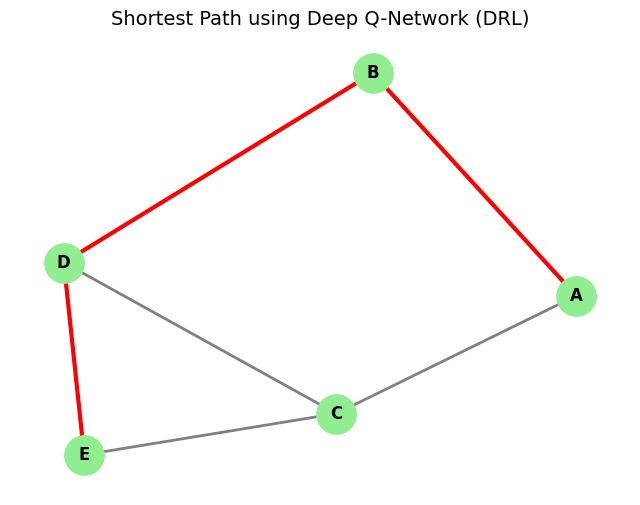

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random
import numpy as np # Import numpy for state_to_one_hot
import networkx as nx # Import networkx as it is used for G
import matplotlib.pyplot as plt # Import matplotlib for plotting

# --- G, states, actions, goal, start are defined explicitly here for self-containment ---
G = nx.Graph()
G.add_edges_from([
    ('A', 'B', {'weight': 1}),
    ('A', 'C', {'weight': 3}),
    ('B', 'D', {'weight': 1}),
    ('C', 'D', {'weight': 1}),
    ('D', 'E', {'weight': 2}),
    ('C', 'E', {'weight': 4}),
])

states = list(G.nodes)
actions = {state: list(G.neighbors(state)) for state in states}
goal = 'E'  # Goal node
start = 'A'  # Start node

# Correct state_size and action_size for the A-E graph
state_size = len(states) # Number of nodes in the current graph (5)
action_size = state_size # Actions correspond to choosing one of the nodes as next state

# Need a mapping from node name to a consistent numerical index
action_map = {node: i for i, node in enumerate(states)} # Mapping node name to index
reverse_action_map = {i: node for i, node in enumerate(states)} # Reverse mapping

# === Define Neural Network for DQN ===
class DQN(nn.Module):
    def __init__(self, input_size, output_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, output_size)
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# === Initialize Network, Optimizer, and Replay Buffer ===
dqn = DQN(state_size, action_size)
optimizer = optim.Adam(dqn.parameters(), lr=0.01)
loss_fn = nn.MSELoss()
replay_buffer = deque(maxlen=10000)
batch_size = 32

# Convert state to one-hot encoding
def state_to_one_hot(state):
    one_hot = np.zeros(state_size)
    one_hot[states.index(state)] = 1
    return torch.tensor(one_hot, dtype=torch.float32)

def choose_action(state, epsilon):
    if random.random() < epsilon:
        return random.choice(actions[state]) # Returns node name (string)
    else:
        state_tensor = state_to_one_hot(state).unsqueeze(0) # Use helper function
        with torch.no_grad():
            q_values = dqn(state_tensor)

        # Mask invalid actions
        valid_action_indices = [action_map[neighbor] for neighbor in actions[state]]
        masked_q_values = q_values.clone()
        # Set Q-values of invalid actions to a very low number
        all_action_indices_local = list(range(action_size))
        invalid_action_indices = [i for i in all_action_indices_local if i not in valid_action_indices]
        masked_q_values[0, invalid_action_indices] = -float('inf')

        action_index = torch.argmax(masked_q_values).item()
        return reverse_action_map[action_index] # Return node name (string)

def replay_experience():
    if len(replay_buffer) < batch_size:
        return
    batch = random.sample(replay_buffer, batch_size)
    states_batch, actions_batch_indices, rewards_batch, next_states_batch, dones_batch = zip(*batch)

    states_batch = torch.stack([state_to_one_hot(s) for s in states_batch])
    next_states_batch = torch.stack([state_to_one_hot(s) for s in next_states_batch])
    actions_batch_indices = torch.tensor(actions_batch_indices)
    rewards_batch = torch.tensor(rewards_batch, dtype=torch.float32)
    dones_batch = torch.tensor(dones_batch, dtype=torch.float32)

    q_values = dqn(states_batch).gather(1, actions_batch_indices.unsqueeze(1)).squeeze(1)

    next_q_values = dqn(next_states_batch)
    next_max_q_values = []
    for i, next_s_one_hot in enumerate(next_states_batch):
        # Convert one-hot back to node name to get neighbors
        next_s_node_name = reverse_action_map[torch.argmax(next_s_one_hot).item()]
        valid_next_action_indices = [action_map[neighbor] for neighbor in actions[next_s_node_name]]

        masked_next_q_values_single = next_q_values[i].clone()
        all_action_indices_local = list(range(action_size)) # Define here
        invalid_next_action_indices = [j for j in all_action_indices_local if j not in valid_next_action_indices]
        masked_next_q_values_single[invalid_next_action_indices] = -float('inf')
        next_max_q_values.append(torch.max(masked_next_q_values_single))
    next_max_q_values = torch.stack(next_max_q_values)


    targets = rewards_batch + (1 - dones_batch) * 0.9 * next_max_q_values # Assuming gamma=0.9 from context

    loss = loss_fn(q_values, targets.detach())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# === Training Loop ===
for episode in range(1000):
    state = random.choice(states) # Start from a random node (string)
    done = False

    while not done:
        action_name = choose_action(state, epsilon=0.2) # action_name is a string like 'B'
        # Calculate reward directly from G to avoid issues with mismatched reward_matrix
        reward = -G[state][action_name]['weight']
        next_state = action_name # next_state is a string like 'B'
        done = (next_state == goal) # Use 'goal' which is 'E' (string)

        action_index_taken = action_map[next_state] # Store the index of the chosen next state (action)

        replay_buffer.append((state, action_index_taken, reward, next_state, done)) # Add 'done' flag
        replay_experience()

        state = next_state

print("✅ DQN training completed.\n")

# === Find Best Path (DQN) ===
def get_dqn_path(start_node_name, goal_node_name):
    path = [start_node_name]
    state = start_node_name
    while state != goal_node_name:
        state_tensor = state_to_one_hot(state).unsqueeze(0)
        with torch.no_grad():
            q_values = dqn(state_tensor)

        # Mask invalid actions
        valid_action_indices = [action_map[neighbor] for neighbor in actions[state]]
        masked_q_values = q_values.clone()
        all_action_indices_local = list(range(action_size)) # Define here
        invalid_action_indices = [i for i in all_action_indices_local if i not in valid_action_indices]
        masked_q_values[0, invalid_action_indices] = -float('inf')

        next_state_index = torch.argmax(masked_q_values).item()
        next_state = reverse_action_map[next_state_index] # Convert index back to node name

        path.append(next_state)
        state = next_state
        if len(path) > state_size * 2: # Add a safety break to avoid infinite loops
            print("Warning: Path exceeded expected length, likely stuck in loop.")
            break
    return path

best_path_drl = get_dqn_path(start, goal) # Use 'start' and 'goal' (strings)
print(f"🤖 Shortest Path (DQN): {best_path_drl}")

# === Plot DQN Path in RED ===
# Redefine pos for the current graph G with nodes A-E
pos = nx.spring_layout(G, seed=42)

plt.figure(figsize=(8, 6))
nx.draw_networkx_edges(G, pos, edge_color='gray', width=2)
nx.draw_networkx_nodes(G, pos, node_color='lightgreen', node_size=800)
nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold')

# Highlight path in red
path_edges_drl = list(zip(best_path_drl, best_path_drl[1:]))
nx.draw_networkx_edges(G, pos, edgelist=path_edges_drl, edge_color='red', width=3)

plt.title("Shortest Path using Deep Q-Network (DRL)", fontsize=14)
plt.axis('off')
plt.show()

DRL (DQN) for Shortest Path in Graph

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import numpy as np # Import numpy for state_to_one_hot

# Define the DQN model (simple MLP for Q-value approximation)
class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Set up parameters for DQN
# Assuming states and actions are defined from the previous Q-learning cell for the graph
# states = list(G.nodes)
# actions = {state: list(G.neighbors(state)) for state in states}
state_size = len(states)  # Number of nodes
# The action size should be the number of possible next states, which are the nodes.
action_size = state_size # Action size is the number of nodes

# Need a mapping from node name to a consistent numerical index
action_map = {node: i for i, node in enumerate(states)} # Mapping node name to index

gamma = 0.9  # Discount factor
epsilon = 0.2  # Exploration factor
epsilon_decay = 0.995  # Epsilon decay factor
learning_rate = 0.001
batch_size = 64
episodes = 1000
buffer = deque(maxlen=10000)  # Experience replay buffer

# Initialize DQN model, optimizer and loss function
model = DQN(state_size, action_size)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

# Convert state to one-hot encoding
def state_to_one_hot(state):
    one_hot = np.zeros(state_size)
    one_hot[states.index(state)] = 1
    return torch.tensor(one_hot, dtype=torch.float32)

# Select action using epsilon-greedy policy
def select_action(state, epsilon):
    if random.random() < epsilon:
        # Select a random valid action (neighbor)
        action_name = random.choice(actions[state])
        return action_name
    else:
        state_input = state_to_one_hot(state).unsqueeze(0)
        q_values = model(state_input)
        # Get the indices of valid actions (neighboring nodes) for the current state
        valid_action_indices = [action_map[neighbor] for neighbor in actions[state]]
        # Mask out invalid actions by setting their Q-values to a very low number
        masked_q_values = q_values.clone()
        all_action_indices = list(range(action_size)) # Action size is now state_size
        invalid_action_indices = [i for i in all_action_indices if i not in valid_action_indices]
        masked_q_values[0, invalid_action_indices] = -float('inf') # Mask invalid actions
        # Select the action (neighboring node index) with the highest Q-value among valid actions
        action_index = torch.argmax(masked_q_values).item()
        # Convert the action index back to the action name (node name)
        # Need a reverse mapping from index to node name
        reverse_action_map = {v: k for k, v in action_map.items()}
        action_name = reverse_action_map[action_index]
        return action_name


# Training loop for DQN
for episode in range(episodes):
    state = start
    total_reward = 0
    path = []

    while state != goal:
        action = select_action(state, epsilon)

        # Take action and observe the next state
        next_state = action
        reward = -G[state][next_state]['weight']  # Negative reward for longer paths

        # Store the experience in the replay buffer
        # The action taken is the next state name. Store its index.
        action_index_taken = action_map[next_state] # Store the index of the next state (action)
        buffer.append((state, action_index_taken, reward, next_state))

        # Sample from the replay buffer and perform learning
        if len(buffer) > batch_size:
            batch = random.sample(buffer, batch_size)
            states_batch, actions_batch_indices, rewards_batch, next_states_batch = zip(*batch)

            states_batch = torch.stack([state_to_one_hot(s) for s in states_batch])
            next_states_batch = torch.stack([state_to_one_hot(s) for s in next_states_batch])
            # Use the stored numerical action indices (which are next state indices)
            actions_batch_indices = torch.tensor(actions_batch_indices)
            rewards_batch = torch.tensor(rewards_batch, dtype=torch.float32)

            # Compute Q-values for states
            q_values = model(states_batch)
            next_q_values = model(next_states_batch)

            # Compute the maximum Q-value for the next states, considering only valid actions from next_state
            next_max_q_values = []
            for i, next_s in enumerate(next_states_batch):
                # Get valid action indices for the actual next state node name
                next_state_node_name = states[torch.argmax(next_s).item()] # Convert one-hot back to node name
                valid_next_action_indices = [action_map[neighbor] for neighbor in actions[next_state_node_name]]

                masked_next_q_values = next_q_values[i].clone()
                all_action_indices = list(range(action_size))
                invalid_next_action_indices = [j for j in all_action_indices if j not in valid_next_action_indices]
                masked_next_q_values[invalid_next_action_indices] = -float('inf') # Mask invalid actions for the next state

                next_max_q_values.append(torch.max(masked_next_q_values))

            next_max_q_values = torch.stack(next_max_q_values)


            # Compute target Q-values
            target_q_values = rewards_batch + gamma * next_max_q_values

            # Compute loss
            # Use the numerical action indices to gather Q-values
            # actions_batch_indices now correctly correspond to the indices of the chosen next states (actions)
            q_value_for_actions = q_values.gather(1, actions_batch_indices.unsqueeze(1)).squeeze(1)
            loss = criterion(q_value_for_actions, target_q_values)

            # Optimize the model
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        state = next_state
        total_reward += reward
        path.append(state)

        if state == goal:
            break

    epsilon *= epsilon_decay  # Decay epsilon
    if episode % 100 == 0:
        print(f"Episode {episode}, Path: {path}, Total Reward: {total_reward}")

print("Training finished!")

# Test the learned policy
state = start
dqn_path = [state]
while state != goal:
    # Select action using greedy policy (no exploration)
    state_input = state_to_one_hot(state).unsqueeze(0)
    q_values = model(state_input)
    # Get the indices of valid actions for the current state
    valid_action_indices = [action_map[neighbor] for neighbor in actions[state]]
    # Mask out invalid actions
    masked_q_values = q_values.clone()
    all_action_indices = list(range(action_size))
    invalid_action_indices = [i for i in all_action_indices if i not in valid_action_indices]
    masked_q_values[0, invalid_action_indices] = -float('inf')
    # Select the action with the highest Q-value among valid actions (which are next state indices)
    action_index = torch.argmax(masked_q_values).item()
    # Convert the action index back to the action name (node name)
    reverse_action_map = {v: k for k, v in action_map.items()}
    action = reverse_action_map[action_index]

    state = action
    dqn_path.append(state)

print("Shortest Path found by DQN:", dqn_path)

Episode 0, Path: ['B', 'D', 'B', 'A', 'B', 'D', 'B', 'D', 'B', 'D', 'B', 'D', 'B', 'D', 'B', 'D', 'B', 'D', 'B', 'D', 'B', 'D', 'B', 'D', 'B', 'D', 'B', 'D', 'B', 'D', 'B', 'D', 'C', 'E'], Total Reward: -37
Episode 100, Path: ['B', 'D', 'E'], Total Reward: -4
Episode 200, Path: ['B', 'D', 'E'], Total Reward: -4
Episode 300, Path: ['B', 'D', 'E'], Total Reward: -4
Episode 400, Path: ['B', 'D', 'E'], Total Reward: -4
Episode 500, Path: ['B', 'D', 'E'], Total Reward: -4
Episode 600, Path: ['B', 'D', 'E'], Total Reward: -4
Episode 700, Path: ['B', 'A', 'B', 'D', 'E'], Total Reward: -6
Episode 800, Path: ['B', 'D', 'E'], Total Reward: -4
Episode 900, Path: ['B', 'D', 'E'], Total Reward: -4
Training finished!
Shortest Path found by DQN: ['A', 'B', 'D', 'E']


In [15]:
import pandas as pd

comparison_data = {
    "Algorithm": ["Q-Learning (RL)", "Deep Q-Network (DRL)"],
    "Shortest Path": [str(best_path_rl), str(best_path_drl)],
    "Path Length": [len(best_path_rl), len(best_path_drl)]
}

comparison_table = pd.DataFrame(comparison_data)
print("\n📊 Performance Comparison between RL and DRL:\n")
print(comparison_table.to_string(index=False))



📊 Performance Comparison between RL and DRL:

           Algorithm                                           Shortest Path  Path Length
     Q-Learning (RL) [0, np.int64(1), np.int64(0), np.int64(1), np.int64(0)]            5
Deep Q-Network (DRL)                                    ['A', 'B', 'D', 'E']            4
